In [3]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./test2.png')

In [9]:
import pandas as pd

pd.value_counts(img.flatten())

0    135000
dtype: int64

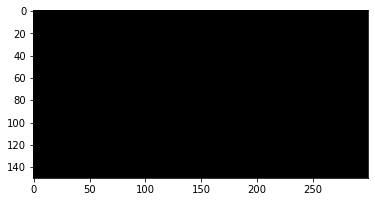

In [4]:
plt.imshow(img)

### 데이터 불러오기

In [1]:
from tensorflow.keras.datasets.mnist import load_data
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state = 777, test_size = 0.3)

x_train = (x_train/255.)[..., np.newaxis]
x_val = (x_val/255.)[..., np.newaxis]
x_test = (x_test/255.)[..., np.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)

### 모델 정의하기

In [11]:
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Dense, Flatten
from tensorflow.keras.models import Model

class ConvModel(Model):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = Conv2D(32, 3, padding = 'same', activation = 'relu')
        self.maxpool1 = MaxPool2D((2, 2))
        self.flatten = Flatten()
        self.d1 = Dense(128, activation = 'relu')
        self.d2 = Dense(10, activation = 'softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.flatten(x)
        x = self.d1(x)
        
        return self.d2(x)
    
def mnist_model():
    inputs = Input(shape=(28, 28, 1))
    
    x = Conv2D(32, 3, padding = 'same', activation = 'relu')(inputs)
    x = MaxPool2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(10, activation = 'softmax')(x)
    
    model = Model(inputs = inputs, outputs = x)
    
    return model

# model = ConvModel()
model = mnist_model()

### 학습 준비

In [12]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean

loss_object = SparseCategoricalCrossentropy()
optimizer = Adam()

train_loss = Mean(name = 'train_loss')
train_acc = SparseCategoricalAccuracy(name = 'train_acc')

val_loss = Mean(name = 'val_loss')
val_acc = SparseCategoricalAccuracy(name = 'val_acc')

### 학습

In [13]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        output = model(images)
        loss = loss_object(labels, output)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_acc(labels, output)
    
@tf.function
def val_step(images, labels):
    output = model(images)
    v_loss = loss_object(labels, output)
    
    val_loss(v_loss)
    val_acc(labels, output)
    
epochs = 10
    
for epoch in range(epochs):
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for images, labels in val_ds:
        val_step(images, labels)
        
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        val_loss.result(),
                        val_acc.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.1785806566476822, Accuracy: 94.76905059814453, Test Loss: 0.07823982834815979, Test Accuracy: 97.65555572509766
Epoch 2, Loss: 0.06067364662885666, Accuracy: 98.15238189697266, Test Loss: 0.06014944240450859, Test Accuracy: 98.22777557373047
Epoch 3, Loss: 0.03603561595082283, Accuracy: 98.9142837524414, Test Loss: 0.05849820747971535, Test Accuracy: 98.3499984741211
Epoch 4, Loss: 0.021314039826393127, Accuracy: 99.40714263916016, Test Loss: 0.06232711300253868, Test Accuracy: 98.22777

### 모델 저장

In [15]:
tf.keras.models.save_model(model, './saved_model/mnist_model.h5', save_format='tf')